In [1]:
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
def get_metrics(y_true, y_hat):
    acc = sklearn.metrics.accuracy_score(y_true, y_hat)
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_true, y_hat)
    return acc, balanced_acc

In [3]:
train_data = np.genfromtxt("datasets/Syndata-train.csv", delimiter=",")[1:]
X_train = train_data[:, :2]
y_train = train_data[:, 2:]

test_data = np.genfromtxt("datasets/Syndata-test.csv", delimiter=",")[1:]
X_test = test_data[:, :2]
y_test = test_data[:, 2:]

In [4]:
class DecisionStump:
    def __init__(self, granularity=10):
        self.best_feature = None
        self.best_direction = None
        self.best_position = None
        self.granularity = granularity

    def train(self, X, y, dist_t):
        """
        arguments:
        X: n✕d training inputs
        y: n✕1 labels with values 1 or -1
        dist_t: n✕1 distribution of samples
        ------------------------------------------
        output:
        e_t: 0/1 loss of h_t which has to be less than 0.5
        """

        X = np.asarray(X)
        y = np.asarray(y)
        dist_t = np.asarray(dist_t)

        # maximum value for error is 1
        e_t = 1
        for feature in range(X.shape[1]):
            err, direction, position = self.__find_best_separator(
                X[:, feature], y, dist_t
            )
            if err < e_t:
                e_t = err
                self.best_feature = feature
                self.best_direction = direction
                self.best_position = position

        return e_t

    # for a given feature, finds the best separator
    def __find_best_separator(self, x, y, dist_t):
        """
        x: n✕1 one feature of inputs
        y: n✕1 labels with values 1 or -1
        dist_t: n✕1 distribution of samples
        ------------------------------------------
        output:
        e_t: 0/1 loss of h_t which has to be less than 0.5
        best_dir: defines which side of the separator gets +1 label
        best_pos: defines the value of the feature used to separate the data
        """

        best_dir = 1
        best_pos = x.min()

        # maximum value for error is 1
        e_t = 1
        for p in np.arange(x.min(), x.max(), (x.max() - x.min()) / self.granularity):
            for d in (-1, 1):
                y_hat = np.ones((y.size)).reshape(-1, 1)
                if d == 1:
                    y_hat[x < p] = -1
                else:
                    y_hat[x > p] = -1

                err = np.sum((y_hat != y) * dist_t)
                if err < e_t:
                    e_t = err
                    best_dir = d
                    best_pos = p

        return e_t, best_dir, best_pos

    def predict(self, X_test):
        """
        X_test: n✕d test inputs
        ------------------------------------------
        output:
        y_hat: n✕1 predicted labels with values 1 or -1
        """

        X_test = np.asarray(X_test)
        if X_test.ndim == 1:
            X_test = X_test[np.newaxis, :]

        y_hat = np.ones((X_test.shape[0]))
        if self.best_direction == 1:
            y_hat[X_test[:, self.best_feature] < self.best_position] = -1
        else:
            y_hat[X_test[:, self.best_feature] > self.best_position] = -1

        return y_hat

In [5]:
# # sample distribution in the algorithm is initialized by 1/N
# sample_dist = np.ones((X_train.shape[0])).reshape(-1,1) / X_train.shape[0]


# dt = DecisionStump()
# train_err = dt.train(X_train, y_train, sample_dist)
# print(f'train error = {train_err}')

# y_test_hat = dt.predict(X_test)
# acc, _ = get_metrics(y_test, y_test_hat)
# print(f'test acc = {acc}')

In [6]:
class AdaBoost:
    def __init__(self, num_iter):
        self.T = num_iter
        self.h = [None for _ in range(self.T)]
        self.alpha = [None for _ in range(self.T)]
        # weak learner loss
        self.e = [None for _ in range(self.T)]

    def __get_new_dist(self, wl, X, y, alpha_t, old_dist):
        new_dist = []
        denominator = 0
        for j in range(X.shape[0]):
            denominator += old_dist[j] * np.exp(-alpha_t * y[j] * wl.predict(X[j]))

        for i in range(X.shape[0]):
            numerator = old_dist[i] * np.exp(-alpha_t * y[i] * wl.predict(X[i]))
            new_dist.append(numerator / denominator)

        return np.asarray(new_dist).reshape(-1, 1)

    
    def train(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # sample distribution is initialized by 1/N
        sample_dist = np.ones((X.shape[0])).reshape(-1, 1) / X.shape[0]
        for t in range(self.T):
            # print(f"------------------ t = {t+1} ------------------")
            wl = DecisionStump()
            self.h[t] = wl
            self.e[t] = wl.train(X, y, sample_dist)
            self.alpha[t] = (1 / 2) * np.log((1 / self.e[t]) - 1)
            sample_dist = self.__get_new_dist(wl, X, y, self.alpha[t], sample_dist)
            

    def predict(self, X, T):
        assert T <= len([i for i in self.h if i is not None])
        X = np.asarray(X)
        y_hat = 0
        for t in range(T):
            y_hat += self.alpha[t] * self.h[t].predict(X)

        return np.sign(y_hat)

In [7]:
T = 20
adaboost = AdaBoost(num_iter=T)
adaboost.train(X_train, y_train)

# How $\epsilon_t$ (zero/one loss of $h_t$) Changes

<function matplotlib.pyplot.show(close=None, block=None)>

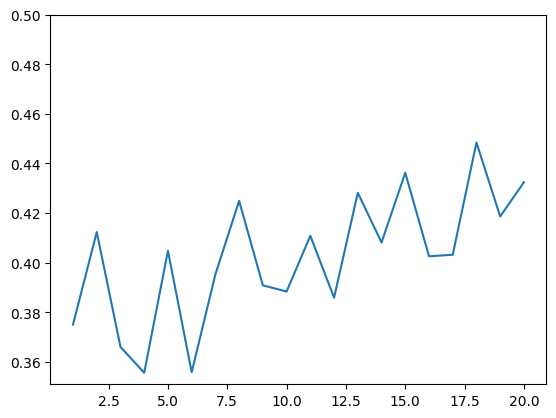

In [8]:
plt.plot(range(1, T + 1), adaboost.e)
plt.ylim(None, 0.5)
plt.show

# How $E_t$ (zero/one loss of $H_t$) Changes

$E_t = \frac{1}{N} \sum_{i=1}^{N} 1_{H_t(x^{(i)}) \neq y^{(i)}}$

this is how $E_t$ changes on training dataset

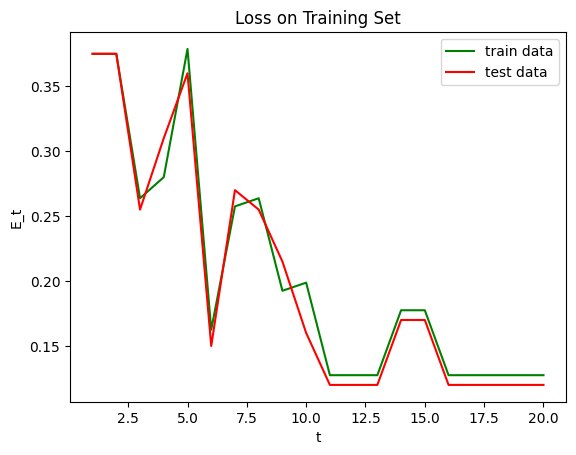

In [9]:
E_train, E_test = [], []
time_steps = range(1, T + 1)
for t in time_steps:
    y_train_hat = adaboost.predict(X_train, t).reshape(-1,1)
    E_train.append(np.sum(y_train != y_train_hat) / y_train.shape[0])

    y_test_hat = adaboost.predict(X_test, t).reshape(-1,1)
    E_test.append(np.sum(y_test != y_test_hat) / y_test.shape[0])

plt.plot(time_steps, E_train, label='Train Data Loss', color='green')
plt.plot(time_steps, E_test, label='Test Data Loss', color='red')
plt.title("Loss")
plt.xlabel("t")
plt.ylabel("E_t")
plt.legend()
plt.show()


# big thing

training is done


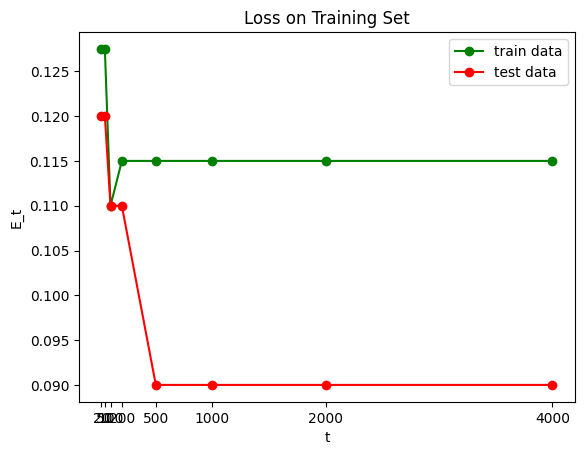

In [10]:
T = 4000
adaboost = AdaBoost(num_iter=T)
adaboost.train(X_train, y_train)
print('training is done')

E_train, E_test = [], []
time_steps = (20, 50, 100, 200, 500, 1000, 2000, 4000)
for t in time_steps:
    y_train_hat = adaboost.predict(X_train, t).reshape(-1, 1)
    E_train.append(np.sum(y_train != y_train_hat) / y_train.shape[0])

    y_test_hat = adaboost.predict(X_test, t).reshape(-1, 1)
    E_test.append(np.sum(y_test != y_test_hat) / y_test.shape[0])

plt.plot(time_steps, E_train, label="Train Data Loss", color="green", marker="o")
plt.plot(time_steps, E_test, label="Test Data Loss", color="red", marker="o")
plt.title("Loss")
plt.xlabel("t")
plt.ylabel("E_t")
plt.legend()
plt.xticks(time_steps)
plt.show()